In [ ]:
from fastai import *
from fastai.vision import *
from fastai.utils.mem import GPUMemTrace, gpu_mem_trace
from fastai.utils.ipython import gpu_mem_restore_ctx
import numpy as np
import sklearn
from sklearn.metrics import roc_auc_score
import pandas as pd
from PIL import ImageFile
import pdb
%pdb
ImageFile.LOAD_TRUNCATED_IMAGES = True
!nvidia-smi

In [68]:
!nvidia-smi

Mon Aug  5 13:29:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |    989MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
Path('/mnt/disks/ssd/data/images/b4_d6_02814870015598852802450.jpg').exists()

False

In [63]:
images_path = Path('/mnt/disks/ssd/data/images/')
train_df = pd.read_csv('data/train_df.csv').sample(100000).dropna()
train_df['file_exists'] = train_df.image_file.map(lambda p: (images_path/p).exists())
train_df = train_df[train_df.file_exists==True]
print(len(train_df))
train_df.head()


98803


,image_file,minerals,is_valid,file_exists
402273,12_0a_04797030014956326443661.jpg,Norbergite|Calcite,1,True
113676,f4_7c_08528110014970111578457.jpg,Silver,0,True
507308,8b_16_03600040014977319032241.jpg,Calcite,1,True
531546,57_be_02780770015042849604395.jpg,Chalcedony|Agate,1,True
611795,9a_f9_03903420015211164711155.jpg,Anatase,1,True


In [64]:
data_path = Path('/mnt/disks/ssd/data/')
data = ImageList.from_df(train_df, folder='images', path=data_path, cols='image_file')\
    .split_from_df(col='is_valid')\
    .label_from_df(cols='minerals', label_delim='|')\
    .transform(tfms=get_transforms(flip_vert=True), size=128)\
    .databunch(bs=512).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (79037 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Silver,Kyanite,Calcite,Topaz;Phlogopite,Aegirine
Path: /mnt/disks/ssd/data;

Valid: LabelList (19766 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Norbergite;Calcite,Calcite,Chalcedony;Agate,Anatase,Quartz;Chalcedony
Path: /mnt/disks/ssd/data;

Test: None

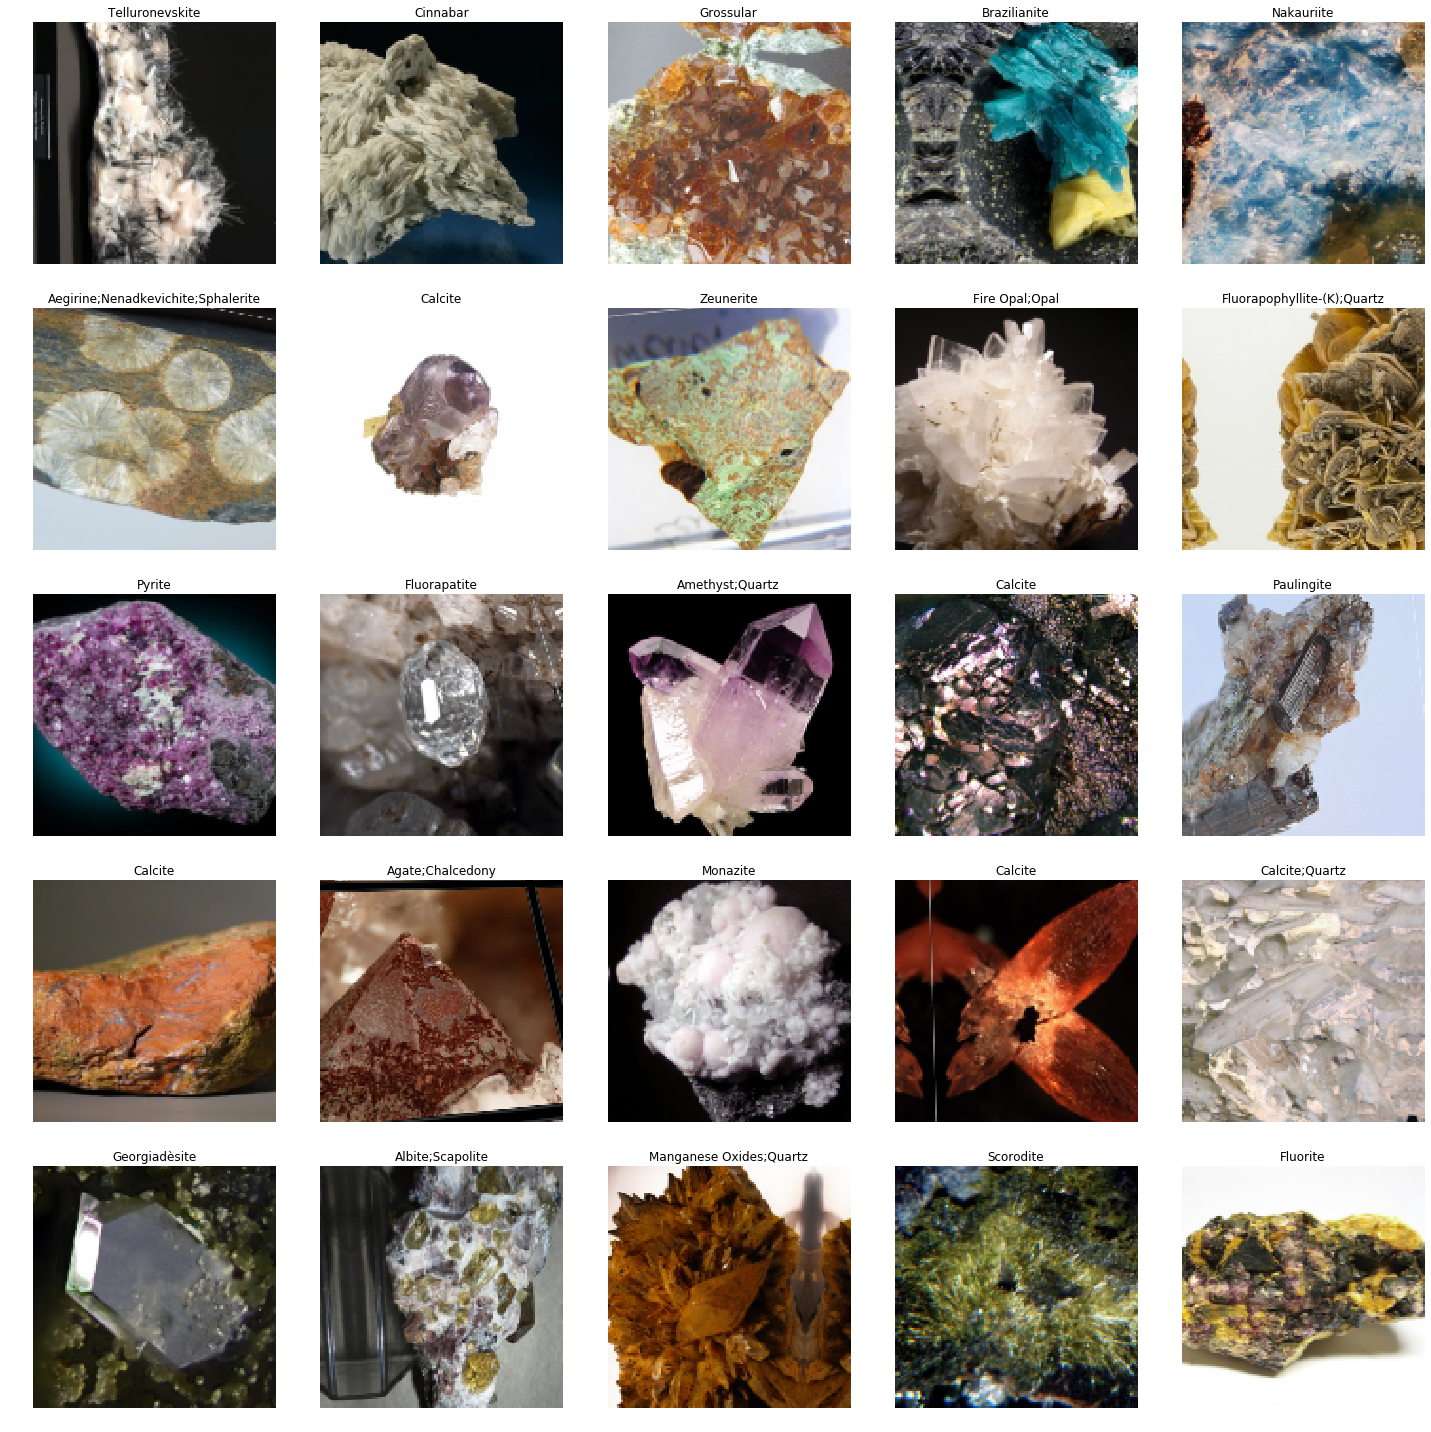

In [5]:
data.show_batch()

In [65]:
def multiclass_metrics(thresh=0.2):
    def true_pos(inputs, targs):
        #pdb.set_trace()
        inps = inputs.sigmoid() >= thresh
        return (inps & targs.byte()).sum().float()
    
    def precision(inputs, targs):  return true_pos(inputs, targs)/(inputs.sigmoid() >= thresh).sum()   
    def recall(inputs, targs):     return true_pos(inputs, targs)/targs.sum()
    
    def fbeta_func(beta):
        def fbeta(inputs, targs):
            prec = precision(inputs, targs)
            rec = recall(inputs, targs)
            return (1+beta**2)*(prec*rec/(beta**2*prec+rec))
        return fbeta
    return [precision, recall, fbeta_func(1.), fbeta_func(2.), fbeta_func(.5), true_pos]

def auc(inputs, targs, sig=True):
    if sig:
        inputs = inputs.sigmoid()
    return torch.Tensor([roc_auc_score(targs, inputs, average='micro')])

@dataclass
class AUROC(Callback):
    "Computes the area under the curve (AUC) score based on the receiver operator characteristic (ROC) curve. Restricted to binary classification tasks."
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = LongTensor([]), Tensor([])
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.sigmoid()
        self.preds = torch.cat((self.preds, last_output.cpu()))
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, auc(self.preds, self.targs, sig=False))


In [66]:
# acc = lambda thresh: partial(accuracy_thresh, thresh=thresh)
# f_score = lambda thresh: partial(fbeta, thresh=thresh)
# metrics = [Precision(), Recall(), FBeta(beta=1.0), acc(0.1), f_score(0.1)]
learn = cnn_learner(data, models.resnet50, metrics=multiclass_metrics(.05) + [AUROC()], path='.').to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
△Used Peaked MB:     64  8,336 (exit)


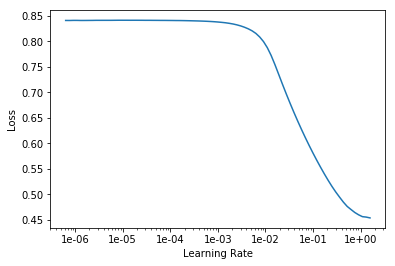

In [67]:
with gpu_mem_restore_ctx():
    with GPUMemTrace():
        learn.lr_find()
        learn.recorder.plot()

epoch,train_loss,valid_loss,precision,recall,fbeta,fbeta,fbeta,true_pos,auroc,time
0,0.228100,0.010935,0.079737,0.192789,0.112738,0.150082,0.090306,37.333332,0.837672,00:36
1,0.058276,0.006541,0.098153,0.182573,0.127578,0.155672,0.108119,35.238094,0.894186,00:36
2,0.021103,0.006083,0.109430,0.165913,0.131763,0.150278,0.117373,32.015873,0.898758,00:34
3,0.010885,0.006068,0.104109,0.182915,0.132576,0.158736,0.113878,35.285713,0.898034,00:50
4,0.007848,0.006011,0.109004,0.185792,0.137293,0.162738,0.118783,35.873016,0.903216,00:33


> <ipython-input-52-c9176fe836c7>(20)auc()
-> if sig:
(Pdb) c
> <ipython-input-52-c9176fe836c7>(20)auc()
-> if sig:
(Pdb) c
> <ipython-input-52-c9176fe836c7>(20)auc()
-> if sig:
(Pdb) c
> <ipython-input-52-c9176fe836c7>(20)auc()
-> if sig:
(Pdb) c
> <ipython-input-52-c9176fe836c7>(20)auc()
-> if sig:
(Pdb) c
△Used Peaked MB:     70  2,020 (exit)


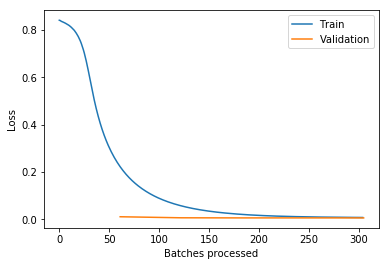

In [54]:
with gpu_mem_restore_ctx():
    with GPUMemTrace():
        learn.fit_one_cycle(5, max_lr=1e-1, wd=0.05)
        learn.recorder.plot_losses()

In [ ]:
with gpu_mem_restore_ctx():
    with GPUMemTrace():
        learn.fit_one_cycle(5, max_lr=1e-1, wd=0.05)
        learn.recorder.plot_losses()

epoch,train_loss,valid_loss,precision,recall,fbeta,fbeta,fbeta,true_pos,auroc,time
0,0.018172,0.013389,0.052574,0.063808,0.057629,0.061178,0.054482,52.696548,0.733983,04:49
1,0.003427,0.002664,0.102817,0.190843,0.133609,0.162910,0.113255,157.556610,0.923020,04:42


In [27]:
learn.save('stage1-128')
learn.unfreeze()
with gpu_mem_restore_ctx():
    with GPUMemTrace():
        learn.fit_one_cycle(5, max_lr=slice(3e-4, 5e-3), wd=0.05)
        learn.recorder.plot_losses()

epoch,train_loss,valid_loss,precision,recall,fbeta,fbeta,fbeta,true_pos,auc,time
0,0.002576,0.002529,0.102593,0.184803,0.131747,0.159060,0.112535,19.082088,0.942854,05:44


△Used Peaked MB:    352    888 (exit)


KeyboardInterrupt: 

> /opt/anaconda3/lib/python3.7/site-packages/fastai/callbacks/fp16.py(60)grad_overflow()
     58         for p in group:
     59             if p.grad is not None:
---> 60                 s = float(p.grad.data.float().sum())
     61                 if s == float('inf') or s == float('-inf') or s != s: return True
     62     return False

--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> q


epoch,train_loss,valid_loss,precision,recall,fbeta,fbeta,fbeta,true_pos,auc,time
0,0.002649,0.002564,0.094603,0.191846,0.126572,0.158946,0.105221,19.812252,0.937400,05:40
1,0.002659,0.002583,0.100414,0.186499,0.130398,0.159036,0.110571,19.256325,0.935216,05:44
2,0.007253,0.004459,0.088595,0.163813,0.114867,0.139885,0.097503,16.916286,0.910390,05:42
3,0.002610,0.002549,0.100391,0.186529,0.130386,0.159041,0.110550,19.259575,0.940945,05:44
4,0.002578,0.002528,0.100393,0.186529,0.130388,0.159042,0.110552,19.259575,0.943168,05:40


△Used Peaked MB:     78    828 (exit)


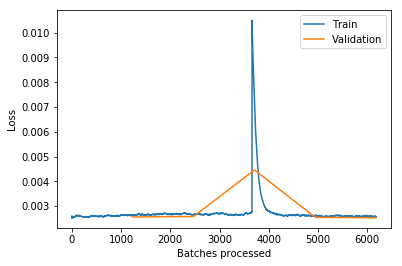

In [28]:
with gpu_mem_restore_ctx():
    with GPUMemTrace():
        learn.fit_one_cycle(5, max_lr=slice(3e-2, 2e-2), wd=0.05)
        learn.recorder.plot_losses()

In [39]:
learn.validate(metrics = multiclass_metrics(0.0001))

[0.0024972388, tensor(nan), tensor(0.), tensor(nan), tensor(nan), tensor(nan)]

In [40]:
learn.validate(metrics = multiclass_metrics(0.000001))

[0.0024972388, tensor(nan), tensor(0.), tensor(nan), tensor(nan), tensor(nan)]

In [42]:
preds = learn.get_preds()
preds

[tensor([[2.5268e-05, 1.8778e-05, 3.0634e-03,  ..., 1.6315e-05, 1.6442e-05,
          4.0064e-05],
         [2.3924e-05, 1.5567e-05, 3.2603e-03,  ..., 1.4739e-05, 1.3955e-05,
          3.0479e-05],
         [2.2474e-05, 1.8200e-05, 2.1912e-03,  ..., 1.5813e-05, 1.2906e-05,
          3.3475e-05],
         ...,
         [2.3007e-05, 1.5690e-05, 2.7900e-03,  ..., 1.4064e-05, 1.3420e-05,
          3.0242e-05],
         [2.1953e-05, 1.6062e-05, 2.7792e-03,  ..., 1.5326e-05, 1.3212e-05,
          3.2192e-05],
         [2.6070e-05, 1.9074e-05, 2.7576e-03,  ..., 1.8059e-05, 1.4739e-05,
          3.9443e-05]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

In [50]:
#preds[0].size(), ByteTensor([i.data for i in data.y]).size()
inputs = preds[0]
targs = ByteTensor([i.data for i in data.valid_ds.y])
inputs.size(), targs.size()

(torch.Size([19869, 3977]), torch.Size([19869, 3977]))

In [61]:
inputs.mean(), targs.float().mean()
thresh = targs.float().mean()
#multiclass_metrics(thresh)[3](inputs, targs)
[[met(inputs, targs) for met in multiclass_metrics(thresh)] for thresh in [4e-5, 4e-4, 4e-3, 4e-2, 4e-1]]

[[tensor(0.0008),
  tensor(0.9721),
  tensor(0.0017),
  tensor(0.0041),
  tensor(0.0010),
  tensor(31190.)],
 [tensor(0.0035),
  tensor(0.8579),
  tensor(0.0070),
  tensor(0.0173),
  tensor(0.0044),
  tensor(27525.)],
 [tensor(0.0142),
  tensor(0.6174),
  tensor(0.0277),
  tensor(0.0650),
  tensor(0.0176),
  tensor(19810.)],
 [tensor(0.0973),
  tensor(0.2037),
  tensor(0.1317),
  tensor(0.1672),
  tensor(0.1086),
  tensor(6537.)],
 [tensor(nan), tensor(0.), tensor(nan), tensor(nan), tensor(nan), tensor(0.)]]

In [77]:
[met(inputs, targs) for met in learn.metrics]

[tensor(0.0004),
 tensor(1.),
 tensor(0.0008),
 tensor(0.0020),
 tensor(0.0005),
 tensor(32084.)]